In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil
import cv2 as cv

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, save_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

2024-09-17 02:48:04.874101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 02:48:04.874223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 02:48:04.999525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = r'/kaggle/input/cauli12/Original Dataset/'
type_disea = os.listdir(data)
print(type_disea)
for i in type_disea:
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/test', i), exist_ok=True)
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/train', i), exist_ok=True)

def split_data_files(X, Y):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
  for i in range(len(X_train)): shutil.copy(os.path.join(os.path.join(data, y_train[i]),X_train[i]), os.path.join('/kaggle/working/dataset_split/train', y_train[i]))
  for i in range(len(X_test)) : shutil.copy(os.path.join(os.path.join(data, y_test[i]),X_test[i]), os.path.join('/kaggle/working/dataset_split/test', y_test[i]))
  
for folder in type_disea:
  X,Y = [],[]
  curr_path = os.path.join(data, folder)
  for filename in os.listdir(curr_path):
    X.append(filename)
    Y.append(folder)
  split_data_files(X, Y)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']


In [3]:
data = '/kaggle/working/dataset_split'

In [4]:
def create_df(TYPE):
  filepaths, labels = [],[]
  data_path = os.path.join(data, TYPE)
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
  return df

train_df = create_df('train').sample(frac=1, random_state=42)
test_df = create_df('test').sample(frac=1, random_state=42)

In [5]:
batch_size=20
img_size = (224, 224)
test  = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False)

Found 133 validated image filenames belonging to 4 classes.


In [6]:
img_shape = (img_size[0], img_size[1], 3)
def get_model():
  base_model = tf.keras.applications.efficientnet.EfficientNetB2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
  base_model.trainable = True
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(4, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=outputs)
  lr=.001
  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
def make_balance(df):
  d = []
  for name_disea in type_disea:
    disea_df = df.loc[df['labels'] == name_disea]
#     print("so luong", len(disea_df))
    d.append(disea_df)
  a = pd.concat(d, axis=0)
  return a

In [8]:
def make_balance_train(df):
  minlenarr = []
  for i in type_disea:
    minlenarr.append(len(df.loc[df['labels']==i]))
  
  minlen = min(minlenarr)
  min_disea = type_disea[minlenarr.index(minlen)]
  
#   a = [df.loc[df['labels']==type_disea[0]]]
#   print(df.loc[df['labels']==type_disea[0]] )
#   a = pd.Series(df['labels'])
#   for i in type_disea:
#     a = df.loc[df['labels']==i]
  print('minlenarr ',minlenarr)
  print('type disea ',type_disea) 
  print('min len ',minlen)
  b = pd.DataFrame({})
  for i in type_disea:
    a = df.loc[df['labels'] == i]
    a = a.iloc[:minlen]
    b = pd.concat([b, a], ignore_index=True)
  print(b)
  return b


minlenarr  [113, 64, 113, 128]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  64
                                             filepaths        labels
0    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
1    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
2    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
3    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
4    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
..                                                 ...           ...
251  /kaggle/working/dataset_split/train/No disease...    No disease
252  /kaggle/working/dataset_split/train/No disease...    No disease
253  /kaggle/working/dataset_split/train/No disease...    No disease
254  /kaggle/working/dataset_split/train/No disease...    No disease
255  /kaggle/working/dataset_split/train/No disease...    No disease

[256 rows x 2 columns]
Found 256 validated image f

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726541460.268980     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1726541460.419605     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step - accuracy: 0.4133 - loss: 1.4466 - val_accuracy: 0.4381 - val_loss: 1.5492
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8904 - loss: 0.3476 - val_accuracy: 0.6190 - val_loss: 1.0716
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9595 - loss: 0.1676 - val_accuracy: 0.6762 - val_loss: 1.0680
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9608 - loss: 0.1082 - val_accuracy: 0.7333 - val_loss: 0.8469
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 0.7714 - val_loss: 0.7170
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9918 - loss: 0.0326 - val_accuracy: 0.8000 - val_loss: 0.6183
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9799 - loss: 0.0478 - val_accuracy: 0.8286 - val_loss: 0.4667
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9991 - loss: 0.0129 - val_accuracy: 0.8667 - val_loss: 0.3509
Epoch 9/15
8/8 ━━━

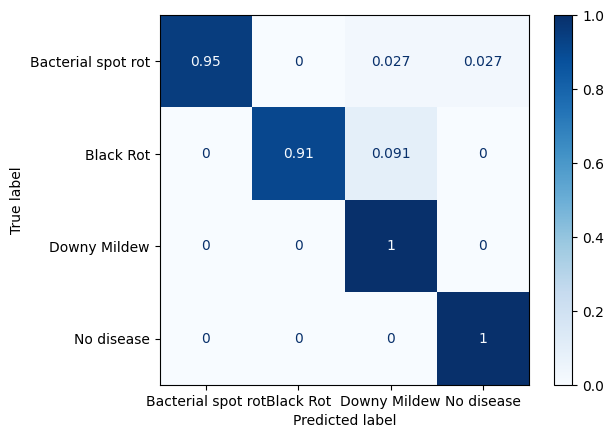

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.95      0.97        37
         Black Rot       1.00      0.91      0.95        22
      Downy Mildew       0.92      1.00      0.96        33
        No disease       0.98      1.00      0.99        41

          accuracy                           0.97       133
         macro avg       0.97      0.96      0.97       133
      weighted avg       0.97      0.97      0.97       133

minlenarr  [115, 63, 108, 132]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  63
                                             filepaths        labels
0    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
1    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
2    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
3    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
4    /kaggle/working/dataset_split/train/Downy Mild

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/8 ━━━━━━━━━━━━━━━━━━━━ 13:33 116s/step - accuracy: 0.2500 - loss: 2.7030

W0000 00:00:1726541997.722448     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 239s 18s/step - accuracy: 0.4710 - loss: 1.5784 - val_accuracy: 0.2857 - val_loss: 14.8165
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9284 - loss: 0.2426 - val_accuracy: 0.2857 - val_loss: 13.5541
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9546 - loss: 0.1656 - val_accuracy: 0.3143 - val_loss: 9.6775
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9814 - loss: 0.0432 - val_accuracy: 0.3429 - val_loss: 6.9004
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9887 - loss: 0.0339 - val_accuracy: 0.4286 - val_loss: 4.6284
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 0.0186 - val_accuracy: 0.4952 - val_loss: 3.3347
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9938 - loss: 0.0205 - val_accuracy: 0.5429 - val_loss: 2.3812
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.6571 - val_loss: 1.7631
Epoch 9/15
8/8 

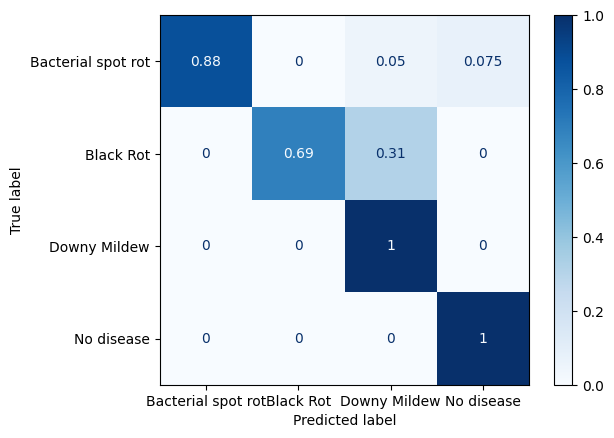

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.88      0.93        40
         Black Rot       1.00      0.69      0.82        29
      Downy Mildew       0.69      1.00      0.82        25
        No disease       0.93      1.00      0.96        39

          accuracy                           0.89       133
         macro avg       0.91      0.89      0.88       133
      weighted avg       0.92      0.89      0.90       133

minlenarr  [111, 65, 111, 131]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  65
                                             filepaths        labels
0    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
1    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
2    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
3    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
4    /kaggle/working/dataset_split/train/Downy Mild

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/9 ━━━━━━━━━━━━━━━━━━━━ 15:49 119s/step - accuracy: 0.3125 - loss: 1.9806

W0000 00:00:1726542624.554431     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 228s 14s/step - accuracy: 0.4439 - loss: 1.4603 - val_accuracy: 0.4667 - val_loss: 3.8201
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8404 - loss: 0.4378 - val_accuracy: 0.4381 - val_loss: 3.8095
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9501 - loss: 0.1834 - val_accuracy: 0.4667 - val_loss: 2.7919
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9473 - loss: 0.1328 - val_accuracy: 0.4667 - val_loss: 2.3520
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9882 - loss: 0.0664 - val_accuracy: 0.5714 - val_loss: 1.6522
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9838 - loss: 0.0625 - val_accuracy: 0.5333 - val_loss: 1.3525
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9870 - loss: 0.0574 - val_accuracy: 0.6381 - val_loss: 1.0261
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9907 - loss: 0.0479 - val_accuracy: 0.7524 - val_loss: 0.6820
Epoch 9/15
9/9 ━━

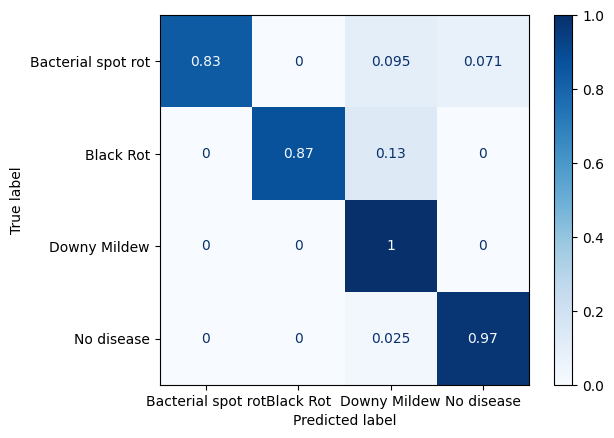

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.83      0.91        42
         Black Rot       1.00      0.87      0.93        23
      Downy Mildew       0.78      1.00      0.88        28
        No disease       0.93      0.97      0.95        40

          accuracy                           0.92       133
         macro avg       0.93      0.92      0.92       133
      weighted avg       0.93      0.92      0.92       133

minlenarr  [117, 63, 102, 137]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  63
                                             filepaths        labels
0    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
1    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
2    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
3    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
4    /kaggle/working/dataset_split/train/Downy Mild

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/8 ━━━━━━━━━━━━━━━━━━━━ 13:54 119s/step - accuracy: 0.1250 - loss: 1.9770

W0000 00:00:1726543231.781439     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 222s 15s/step - accuracy: 0.4156 - loss: 1.4587 - val_accuracy: 0.2692 - val_loss: 5.6084
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8809 - loss: 0.3344 - val_accuracy: 0.2692 - val_loss: 5.3329
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9285 - loss: 0.1869 - val_accuracy: 0.2692 - val_loss: 5.9708
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9656 - loss: 0.1213 - val_accuracy: 0.3173 - val_loss: 5.3474
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9986 - loss: 0.0431 - val_accuracy: 0.3846 - val_loss: 3.5157
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9695 - loss: 0.0573 - val_accuracy: 0.5865 - val_loss: 1.4492
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9986 - loss: 0.0221 - val_accuracy: 0.8173 - val_loss: 0.4602
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9980 - loss: 0.0117 - val_accuracy: 0.9038 - val_loss: 0.3037
Epoch 9/15
8/8 ━━

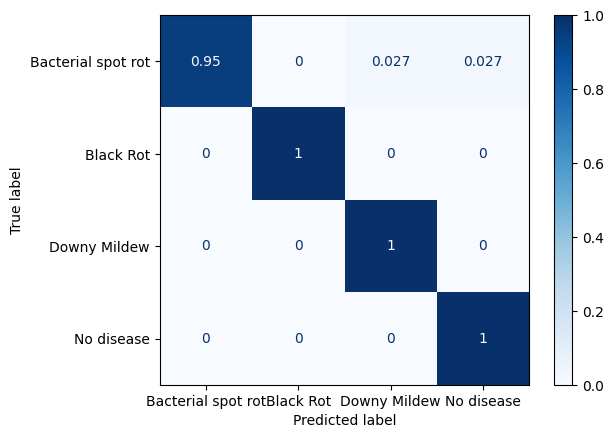

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.95      0.97        37
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       0.97      1.00      0.99        35
        No disease       0.98      1.00      0.99        41

          accuracy                           0.98       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.98      0.98       133

minlenarr  [108, 65, 118, 128]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  65
                                             filepaths        labels
0    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
1    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
2    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
3    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
4    /kaggle/working/dataset_split/train/Downy Mild

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/9 ━━━━━━━━━━━━━━━━━━━━ 16:03 120s/step - accuracy: 0.2188 - loss: 2.2115

W0000 00:00:1726543817.308594     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 218s 12s/step - accuracy: 0.4141 - loss: 1.4829 - val_accuracy: 0.1923 - val_loss: 5.2235
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9268 - loss: 0.2198 - val_accuracy: 0.1923 - val_loss: 4.1691
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9635 - loss: 0.1306 - val_accuracy: 0.5577 - val_loss: 1.5141
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9795 - loss: 0.0844 - val_accuracy: 0.5865 - val_loss: 1.2849
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9908 - loss: 0.0580 - val_accuracy: 0.6635 - val_loss: 1.1217
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 0.7115 - val_loss: 0.8267
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9900 - loss: 0.0269 - val_accuracy: 0.8173 - val_loss: 0.5708
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9933 - loss: 0.0309 - val_accuracy: 0.8462 - val_loss: 0.4668
Epoch 9/15
9/9 ━━

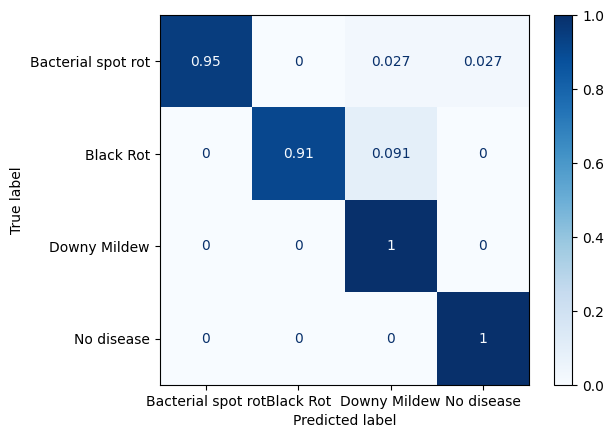

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.95      0.97        37
         Black Rot       1.00      0.91      0.95        22
      Downy Mildew       0.92      1.00      0.96        33
        No disease       0.98      1.00      0.99        41

          accuracy                           0.97       133
         macro avg       0.97      0.96      0.97       133
      weighted avg       0.97      0.97      0.97       133



In [9]:
k = StratifiedKFold(n_splits=5,shuffle=True)
k.get_n_splits(train_df['filepaths'], train_df['labels'])
epochs = 15
gen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
for i, (train_idx, valid_idx) in enumerate(k.split(train_df['filepaths'], train_df['labels'])):
  a = make_balance_train(train_df.loc[train_idx])
  b = train_df.loc[valid_idx]
  train = ImageDataGenerator().flow_from_dataframe(a, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)
  valid = ImageDataGenerator().flow_from_dataframe(b, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)  
  
  model = get_model()
  history = model.fit(x=train, epochs=epochs, validation_data=valid, validation_steps=None, shuffle=False, initial_epoch=0)
  history_dict = history.history
  class_indices = list(train.class_indices.values())
  class_names = list(train.class_indices.keys())
  preds = model.predict(test)
  label = test.labels
  list_pred = []
  errors = 0
  for i, p in enumerate(preds):
    index = np.argmax(p)
    list_pred.append(index)
    if class_indices[index] != label[i]:
      errors+=1
  acc = (1.0 - errors/len(preds)) * 100
  print('Errors = ', errors, "Acc = ", acc)
  cm = confusion_matrix(list_pred, label, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  report = classification_report(list_pred, label,target_names=class_names)
  print(report)